In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

sign = lambda x: (2 * (x >= 0) - 1) * (x != 0)

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def mse(y_true, y_predicted):
    return sum((y_true - y_predicted) ** 2) / len(y_true)

def r2(y_true, y_predicted):
    u = sum((y_true - y_predicted) ** 2)
    v = sum((y_true - np.mean(y_true)) ** 2)
    return 1 - u / v

In [4]:
class NormalLR:
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        n, k = X.shape
        X = np.insert(X, [k], [[1] for i in range(n)], 1)
        self.w = np.linalg.inv(np.dot(X.T, X)).dot(X.T).dot(y)
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        return np.dot(X, self.w[:-1]) + self.w[-1]

In [5]:
class GradientLR:  # линейная регрессия с L1-регуляризацией, где веса оптимизируются градиентным спуском
    
    def __init__(self, alpha:float, iterations=10000, l=0.):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.w = None
    
    def gradient(self, X:np.ndarray, y:np.ndarray):  # считает градиент MSE
        n, k = X.shape
        grad = np.zeros(k)
        for ind in range(k):
            for i in range(n):
                grad[ind] += X[i][ind] * (np.dot(self.w.T, X[i]) - y[i])
            grad[ind] *= 2
            grad[ind] += self.l * sign(self.w[ind])
        return grad
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        n, k = X.shape
        X = np.insert(X, [k], [[1] for i in range(n)], 1)
        self.w = np.zeros(k + 1)
        for _ in range(self.iterations):
            self.w -= self.alpha * self.gradient(X, y)
        
    def predict(self, X:np.ndarray):
        return np.dot(X, self.w[:-1]) + self.w[-1]

In [6]:
def build_plot(X_train, y_train, X_test, y_test, left=0.0, right=0.5, step=0.001, l_rate=0.001, iterat=100):  # график зависимости mse от l
    xs = np.arange(left, right + step, step)
    errors = []
    for x in xs:
        regr = GradientLR(l_rate, iterations=iterat, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.plot(xs, errors)
    plt.show()

In [7]:
# Считываем датасет 'boston.csv'

X, y = read_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [8]:
# Стандартизация X_train, y_train

n, k = X.shape
m = np.zeros(k + 1); st = np.zeros(k + 1)
for i in range(k):
    m[i] = X_train[:, i].mean()
    X_train[:, i] -= m[i]
    st[i] = X_train[:, i].std()
    X_train[:, i] /= st[i]

m[k] = y_train.mean()
y_train -= m[k]
st[k] = y_train.std()
y_train /= st[k]

In [9]:
# Стандартизация X_test, y_test 

for i in range(k):
    X_test[:, i] -= m[i]
    X_test[:, i] /= st[i]
    
y_test -= m[k]
y_test /= st[k]

In [10]:
# Обучение и тестирование обычной линейной регрессии на датасете 'boston.csv'

regr1 = NormalLR()
regr1.fit(X_train, y_train)
y_pred = regr1.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.2537384248924287, R2: 0.6872797475661053


In [11]:
%%time
# Обучение и тестирование линейной регрессии с L1-регуляризацией на датасете 'boston.csv'
regr2 = GradientLR(0.0001, iterations=1000, l=0.2)
regr2.fit(X_train, y_train)
y_pred = regr2.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.25341358206673975, R2: 0.6876801005299651
CPU times: user 1min 23s, sys: 527 ms, total: 1min 23s
Wall time: 1min 23s


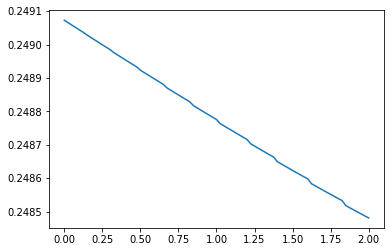

CPU times: user 10min 56s, sys: 1.33 s, total: 10min 57s
Wall time: 10min 58s


In [12]:
%%time
# Зависимость качества линейной модели в зависимости от параметра L1-регуляризации на датасете 'boston.csv'
build_plot(X_train, y_train, X_test, y_test, right=2, step=0.025, l_rate=0.0001)

In [16]:
names = ['Уровень преступности на душу населения',
         'Доля жилой земли, выделенной для участков площадью более 25000 кв. футов',
         'Доля акров на район, не связанных с розничной торговлей',
         'Наличие границы с рекой',
         'Концентрация оксидов азота',
         'Среднее количество комнат на жильё',
         'Доля жилых домов, построенных до 1940 года',
         'Взвешенное расстояние до пяти главных бостонских центров трудоустройства',
         'Индекс доступности радиальных магистралей',
         'Полная ставка налога на имущество (на 10 долларов США)',
         'Соотношение ученик/учитель на район',
         'Величина 1000*(Bk - 0.63)^2, где Bk- доля чернокожего населения на район',
         'Процент низкого статуса населения']

for i in range(len(names)):
    names[i] = (names[i], regr1.w[i])

sorted_names = sorted(names, key = lambda a: a[1])
for name, val in sorted_names:
    print(name, ':', val)

print(f'Ожидаемая стоимость жилья: {regr1.w[-1] * st[-1] + m[-1]}')

Процент низкого статуса населения : -0.42715045045466454
Взвешенное расстояние до пяти главных бостонских центров трудоустройства : -0.3507840513022463
Полная ставка налога на имущество (на 10 долларов США) : -0.26189989038157857
Концентрация оксидов азота : -0.21412570942468168
Соотношение ученик/учитель на район : -0.20986569102242114
Уровень преступности на душу населения : -0.10102289475053695
Доля акров на район, не связанных с розничной торговлей : -0.014638081264638149
Доля жилых домов, построенных до 1940 года : 0.031506602783543836
Наличие границы с рекой : 0.06298855912161305
Величина 1000*(Bk - 0.63)^2, где Bk- доля чернокожего населения на район : 0.08513042915023201
Доля жилой земли, выделенной для участков площадью более 25000 кв. футов : 0.13524571580031575
Среднее количество комнат на жильё : 0.27810465800999984
Индекс доступности радиальных магистралей : 0.3051986739969367
Ожидаемая стоимость жилья: 22505.693069306933


In [17]:
names = ['Уровень преступности на душу населения',
         'Доля жилой земли, выделенной для участков площадью более 25000 кв. футов',
         'Доля акров на район, не связанных с розничной торговлей',
         'Наличие границы с рекой',
         'Концентрация оксидов азота',
         'Среднее количество комнат на жильё',
         'Доля жилых домов, построенных до 1940 года',
         'Взвешенное расстояние до пяти главных бостонских центров трудоустройства',
         'Индекс доступности радиальных магистралей',
         'Полная ставка налога на имущество (на 10 долларов США)',
         'Соотношение ученик/учитель на район',
         'Величина 1000*(Bk - 0.63)^2, где Bk- доля чернокожего населения на район',
         'Процент низкого статуса населения']

for i in range(len(names)):
    names[i] = (names[i], regr2.w[i])

sorted_names = sorted(names, key = lambda a: a[1])
for name, val in sorted_names:
    print(name, ':', val)

print(f'Ожидаемая стоимость жилья: {regr2.w[-1] * st[-1] + m[-1]}')

Процент низкого статуса населения : -0.4267235015345439
Взвешенное расстояние до пяти главных бостонских центров трудоустройства : -0.3495498053093016
Полная ставка налога на имущество (на 10 долларов США) : -0.2568566320238581
Концентрация оксидов азота : -0.2127078701868529
Соотношение ученик/учитель на район : -0.20943451857153664
Уровень преступности на душу населения : -0.10022541101834645
Доля акров на район, не связанных с розничной торговлей : -0.01564882253382383
Доля жилых домов, построенных до 1940 года : 0.03031538404673457
Наличие границы с рекой : 0.06302781372284727
Величина 1000*(Bk - 0.63)^2, где Bk- доля чернокожего населения на район : 0.08491294307673358
Доля жилой земли, выделенной для участков площадью более 25000 кв. футов : 0.13399107109433758
Среднее количество комнат на жильё : 0.27871277503818737
Индекс доступности радиальных магистралей : 0.29992051678244563
Ожидаемая стоимость жилья: 22505.595448863285
